In [65]:
import pandas as pd
data=pd.read_fwf('SDISPR.TXT',header=1,colspecs=[(22,34),(38,52)])
f = data['FREQ']
k = data['FREQ']/data['PHASE VEL']/1e3

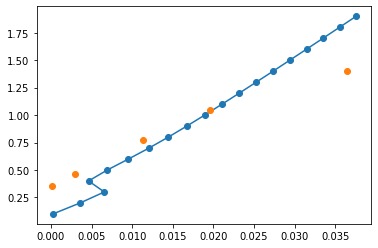

In [66]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots()
fig.patch.set_facecolor('w')
plt.plot(k,f,'-o')
plt.plot( [0.0364, 0.0196, 0.0113, 0.0029, 0.0001], [1.4, 1.05, 0.77, 0.46, 0.35], 'o' )
plt.show()